# Face Recognition 

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import local_binary_pattern as LBP

## Load Folder

In [2]:
def load_images(data_path):
    images = []
    labels = []

    for person_name in os.listdir(data_path):
        person_dir = os.path.join(data_path, person_name)
        if os.path.isdir(person_dir):
            for image_filename in os.listdir(person_dir):
                if image_filename.endswith('.jpg'):
                    image_path = os.path.join(person_dir, image_filename)
                    image = cv2.imread(image_path)

                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    images.append(image)

                    labels.append(person_name)

    images = np.array(images)
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    
    return {
        'data': images,
        'target': labels,
        'target_names': unique_labels
    }

dataset = load_images('./Data/')

In [3]:
# BACKUP
lfw_dataset = dataset.copy()


print("Shape of images:", lfw_dataset['data'].shape)
print("Shape of labels:", lfw_dataset['target'].shape)
print("Unique labels:", lfw_dataset['target_names'].shape)

Shape of images: (13233, 250, 250, 3)
Shape of labels: (13233,)
Unique labels: (5749,)


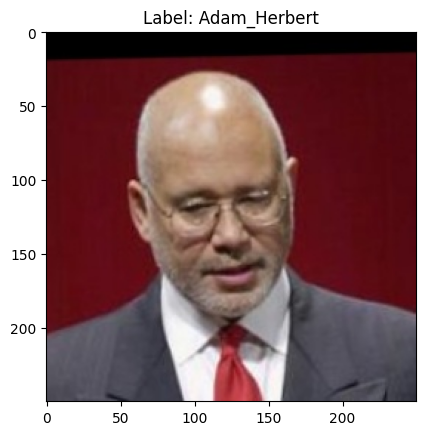

In [5]:
# display an image with its label
first_image = dataset['data'][67]

plt.imshow(first_image)
plt.title(f'Label: {dataset["target"][67]}')
plt.show()

## Data Visualization

### Image Distribuition of Top 20 People

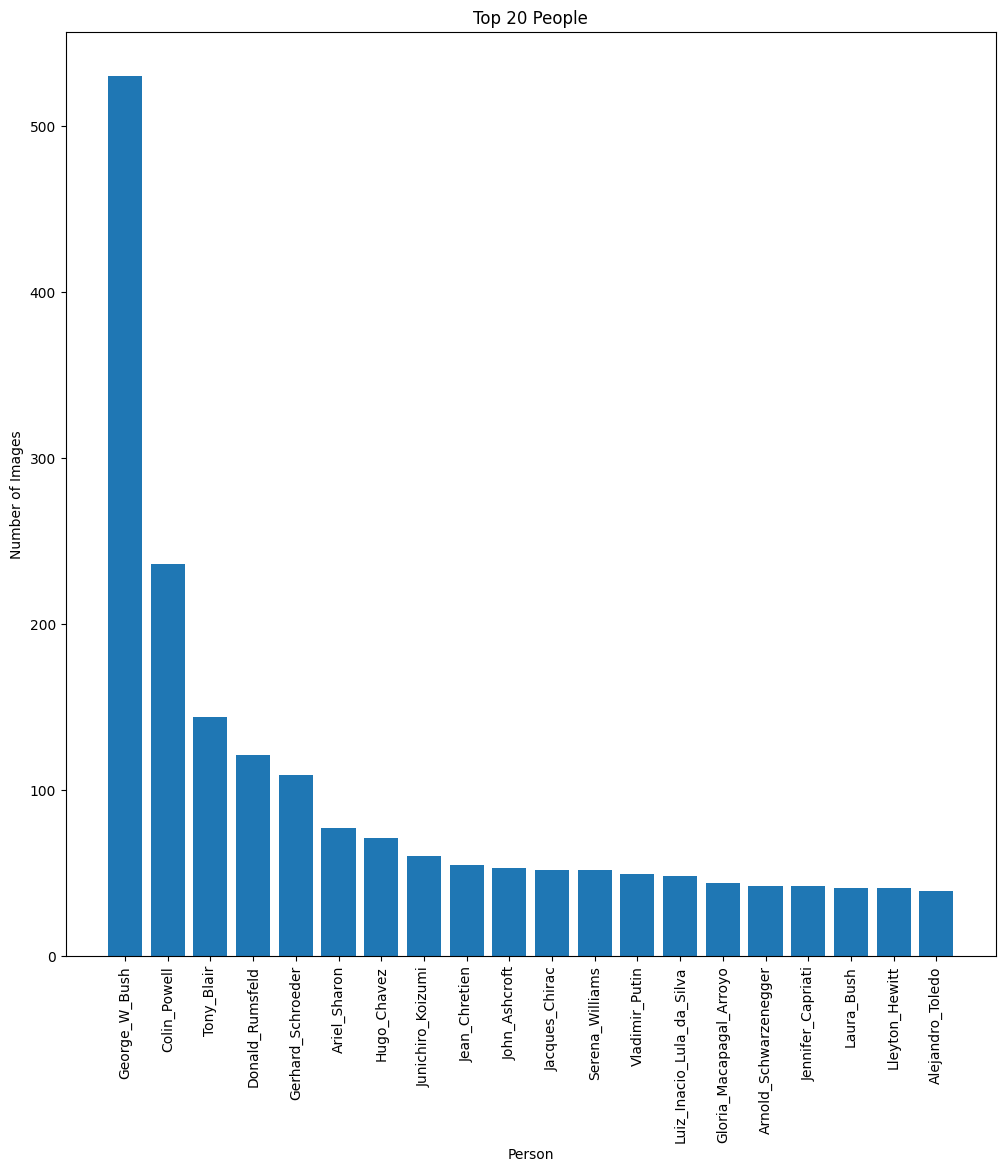

In [6]:
target_counts = Counter(dataset['target'])

top_20_people = target_counts.most_common(20)

plt.figure(figsize=(12, 12))
plt.bar(*zip(*top_20_people))
plt.xlabel('Person')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.title('Top 20 People')
plt.show()

### Histogram

In [7]:
ranges = [(1, 1), (2, 5), (6, 10), (11, 19), (20, 30), (31, 80), (81, np.inf)]
labels = ['1', '2-5', '6-10', '11-19', '20-30', '31-80', '>81']

people_counts = [0] * len(ranges)
image_counts = [0] * len(ranges)

# For each person, increment the count for the appropriate range
for person, count in target_counts.items():
    for i, (min_count, max_count) in enumerate(ranges):
        if min_count <= count <= max_count:
            people_counts[i] += 1
            image_counts[i] += count
            break

# Calculate the percentages
total_people = sum(people_counts)
total_images = sum(image_counts)
people_percentages = [f"{count / total_people * 100:.2f}" for count in people_counts]
images_percentages = [f"{count / total_images * 100:.2f}" for count in image_counts]

# Create a DataFrame
df = pd.DataFrame({
    '# of images /person': labels,
    '# of people': people_counts,
    '% of people': people_percentages,
    '# of images': image_counts,
    '% of images': images_percentages
})

df

,# of images /person,# of people,% of people,# of images,% of images
0,1,4069,70.78,4069,30.75
1,2-5,1369,23.81,3739,28.26
2,6-10,168,2.92,1251,9.45
3,11-19,81,1.41,1151,8.70
4,20-30,30,0.52,713,5.39
5,31-80,27,0.47,1170,8.84
6,>81,5,0.09,1140,8.61


### Distribuition of Pixel Values

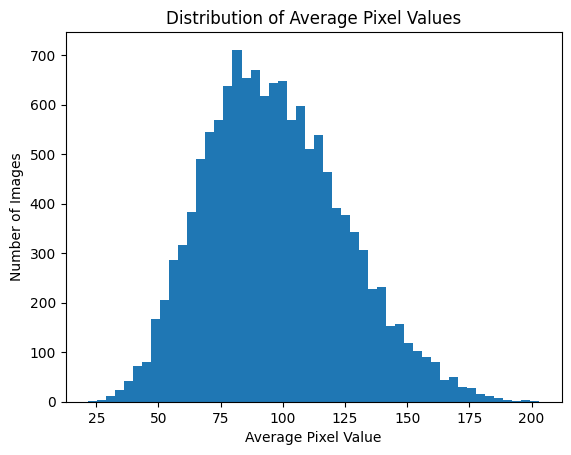

In [8]:
# Distribuition of Pixel Values

# Get the average pixel values for each image
average_pixels = np.mean(dataset['data'], axis=(1, 2, 3))

# Plot the distribution of average pixel values with 50 bins
plt.hist(average_pixels, bins=50)  # Change the number of bins to 50
plt.xlabel('Average Pixel Value')
plt.ylabel('Number of Images')
plt.title('Distribution of Average Pixel Values')

plt.show()

### Plot Some Images

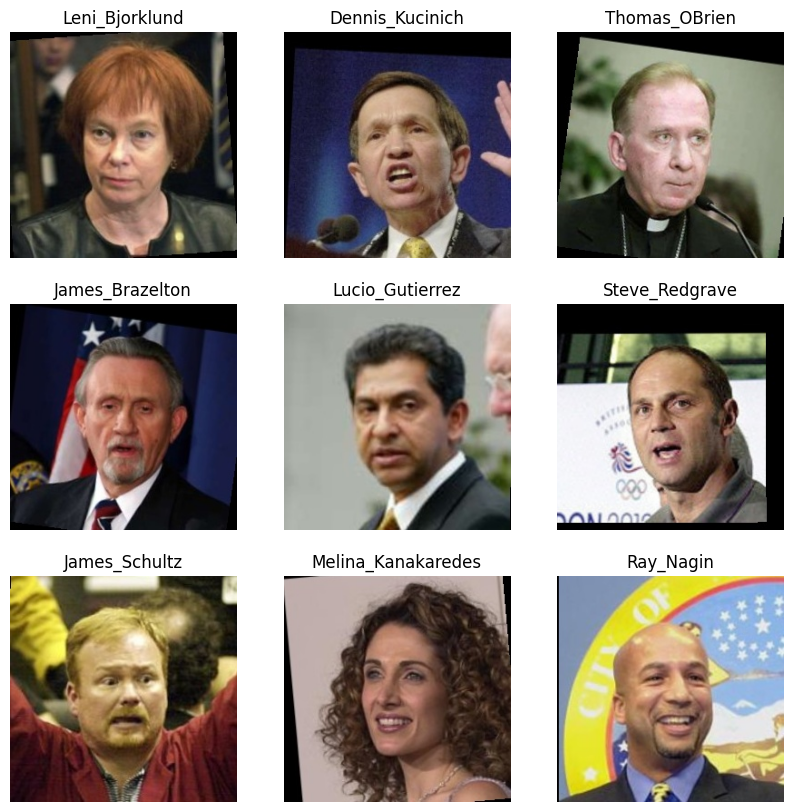

In [9]:
# Function to display a random set of images

def display_random_images(images, labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(labels[index])

    plt.show()

display_random_images(dataset['data'], dataset['target'], 3, 3)

## Data Preprocessing

### Image Resizing

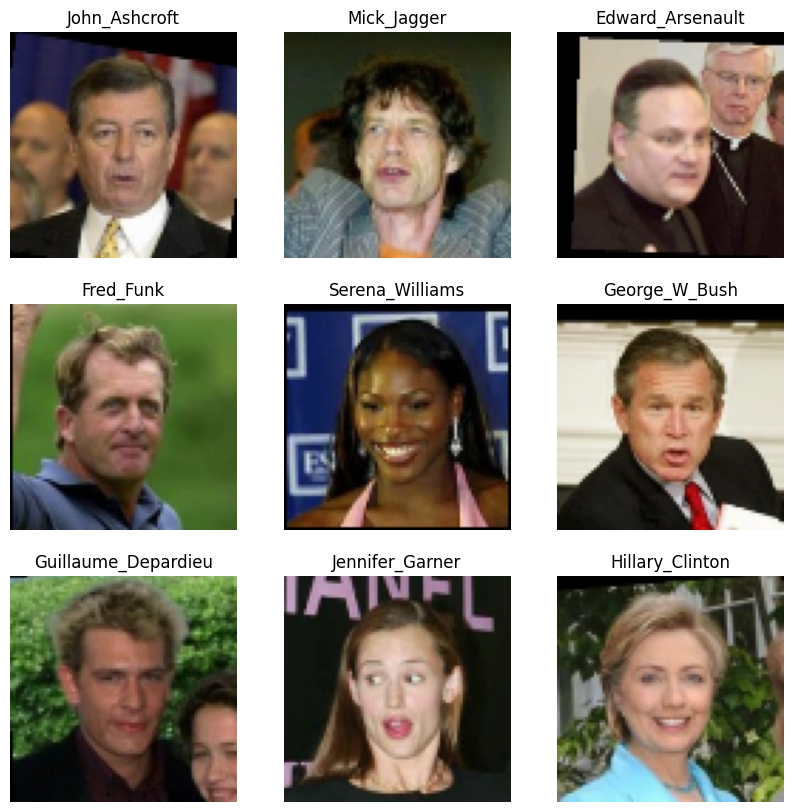

In [10]:
def resize_image(images, target_size=(100, 100)):
    resized_images = [cv2.resize(image, target_size) for image in images]
    return np.array(resized_images)

resized_images = resize_image(dataset['data'], target_size=(80, 80))


display_random_images(resized_images, dataset['target'], 3, 3)

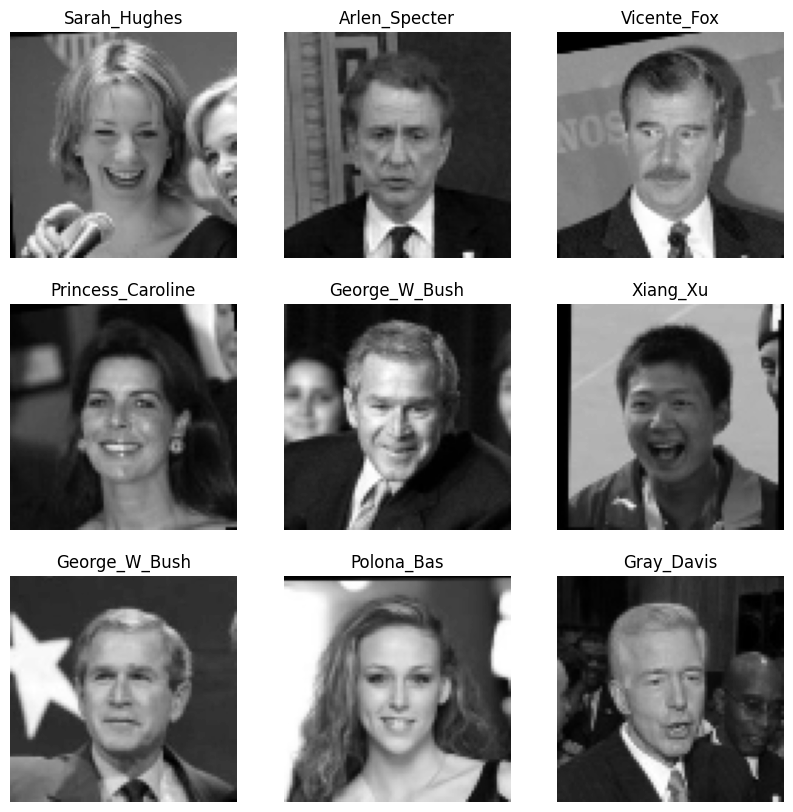

In [11]:
# Gray scale
def gray_scale(images):
    gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images]
    return np.array(gray_images)

gray_images = gray_scale(resized_images)

display_random_images(gray_images, dataset['target'], 3, 3, cmap='gray')

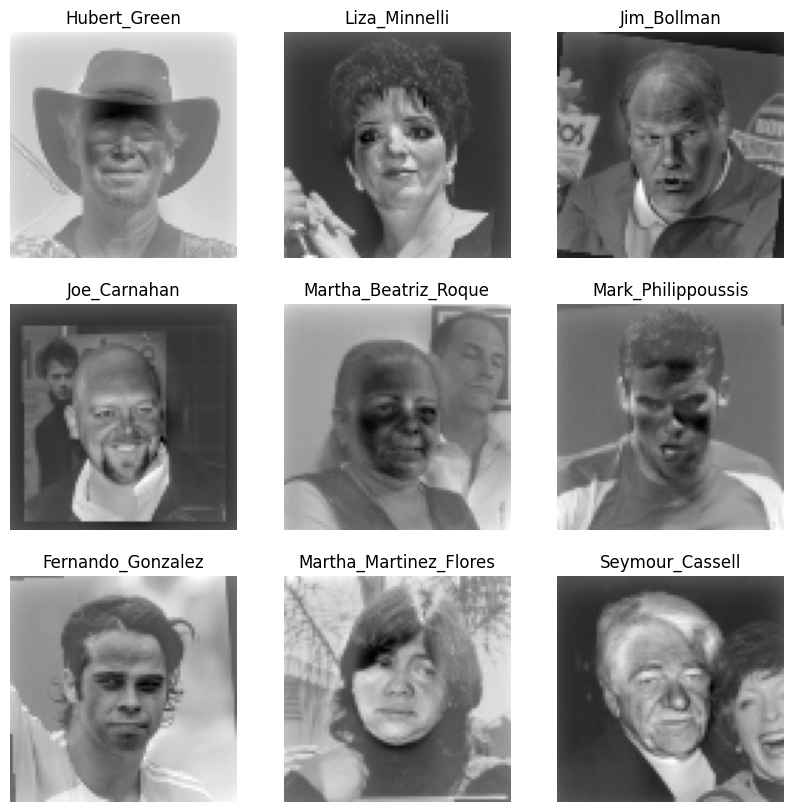

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_images = scaler.fit_transform(gray_images.reshape(-1, 80 * 80)).reshape(-1, 80, 80)


display_random_images(scaled_images, dataset['target'], 3, 3, cmap='gray')

## Feature Extractions

#### Filter Dataset

In [13]:
def filter_dataset(dataset, min_faces_per_person):
    # Count the number of images for each person
    target_counts = Counter(dataset['target'])

    # Initialize the filtered dataset
    filtered_dataset = {
        'data': [],
        'target': [],
        'target_names': set()
    }

    # For each image and its corresponding label
    for image, label in zip(dataset['data'], dataset['target']):
        # If this person has at least min_faces_per_person images
        if target_counts[label] >= min_faces_per_person:
            # Add this image and label to the filtered dataset
            filtered_dataset['data'].append(image)
            filtered_dataset['target'].append(label)
            filtered_dataset['target_names'].add(label)

    filtered_dataset['data'] = np.array(filtered_dataset['data'])
    filtered_dataset['target'] = np.array(filtered_dataset['target'])
    filtered_dataset['target_names'] = np.array(list(filtered_dataset['target_names']))

    return filtered_dataset

dataset['data'] = scaled_images

filtered_dataset = filter_dataset(dataset, min_faces_per_person=30)

In [15]:
filtered_dataset['data'].shape
filtered_dataset['target'].shape


print("Shape of images:", filtered_dataset['data'].shape)

Shape of images: (2370, 80, 80)


### TRAIN-TEST-SPLIT

In [16]:
X = filtered_dataset['data']
y = filtered_dataset['target']

X = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1896, 6400)
Shape of X_test: (474, 6400)
Shape of y_train: (1896,)
Shape of y_test: (474,)


### Principal Component Analysis (Eigenfaces)

#### Principal Component Analysis (PCA):

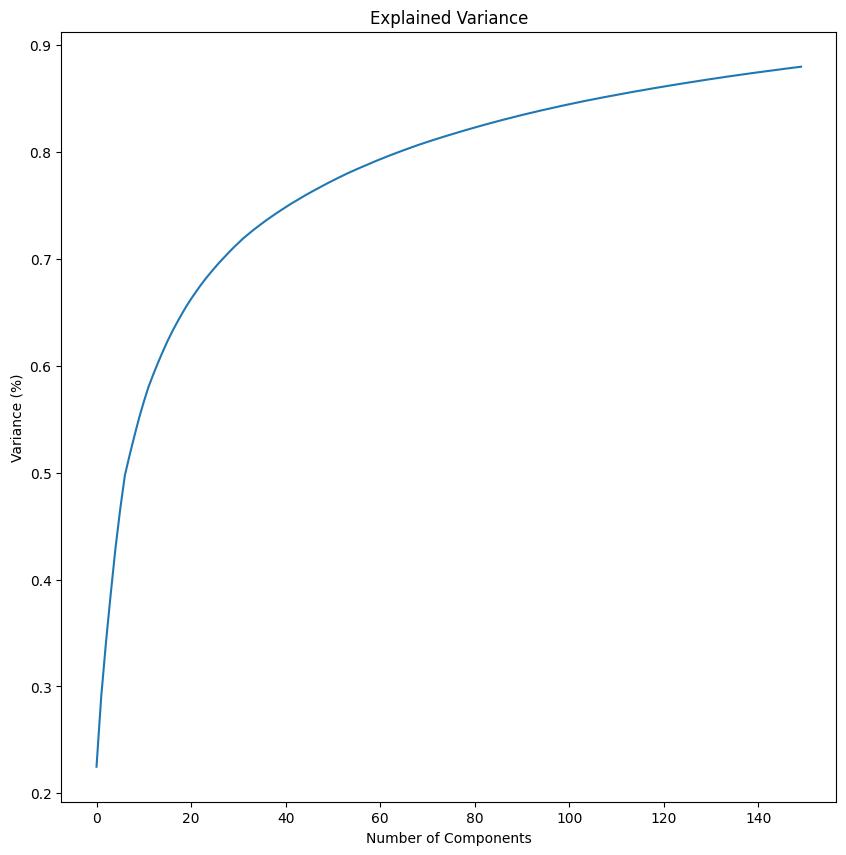

In [20]:
def pca_transform(X_train, X_test, n_components=None):
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca


X_train_pca, X_test_pca, pca = pca_transform(X_train, X_test, n_components=150)

# Function to plot the explained variance ratio
plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

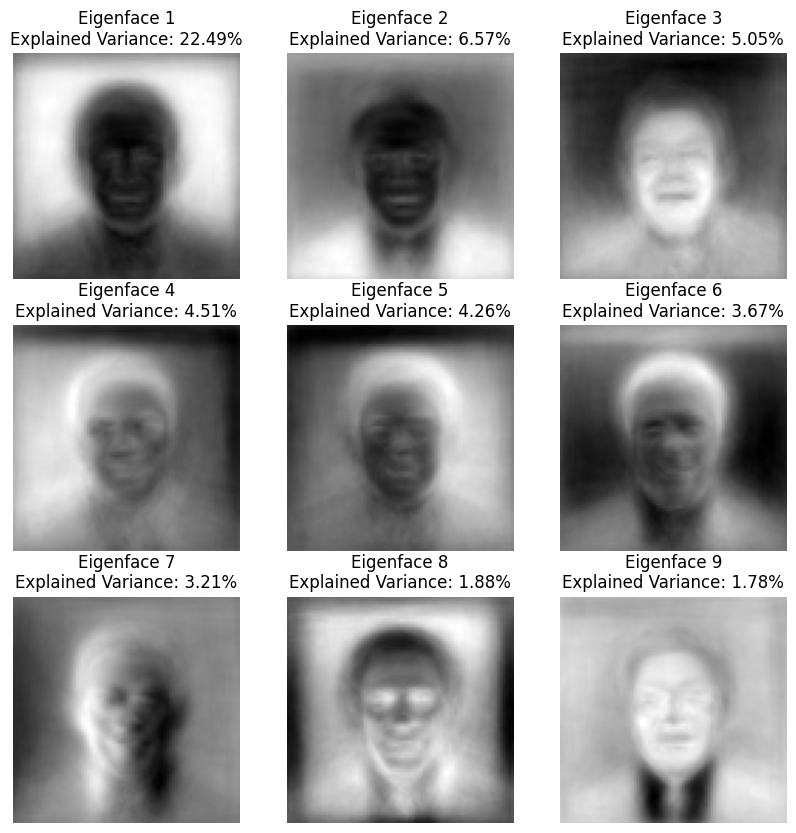

In [21]:
# Assuming pca is your PCA object and X_train is your training data
# Calculate explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the eigenfaces with information in the title
def plot_eigenfaces(components, h, w, rows, cols, explained_variance_ratio):
    plt.figure(figsize=(10, 10))

    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(components[i].reshape((h, w)), cmap='gray')
        plt.title(f'Eigenface {i + 1}\nExplained Variance: {explained_variance_ratio[i]*100:.2f}%')
        plt.axis('off')

    plt.show()

# Assuming your images have dimensions 80x80, adjust as needed
plot_eigenfaces(pca.components_, 80, 80, 3, 3, explained_variance_ratio)

In [22]:
# from sklearn.decomposition import PCA

# X = filtered_dataset['data']
# y = filtered_dataset['target']

# X = X.reshape(-1, 80 * 80)

# pca = PCA(n_components=150, whiten=True, random_state=42)
# X_pca = pca.fit_transform(X)
# # plot the explained variance ratio
# plt.figure(figsize=(12, 8))
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)')
# plt.title('Explained Variance')
# plt.grid(True)
# plt.show()

In [23]:
# # Split the data into training and testing sets using stratified sampling
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# # Create an SVM classifier with the chosen parameters
# clf = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)

# # Train the model on the training set
# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)
# accuracy_pca = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy_pca )
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

### Local Binary Patterns (LBP):

In [24]:
# from skimage import feature
# import numpy as np

# def extract_lbp_features(images, image_shape):
#     lbp_features = []

#     for image in images:
#         # Reshape the flattened image to 2D
#         image = image.reshape(image_shape)

#         # Compute LBP features
#         lbp = feature.local_binary_pattern(image, P=8, R=1, method="uniform")

#         # Flatten the LBP features and append to the list
#         lbp_features.append(lbp.flatten())

#     return np.array(lbp_features)

# # Assuming X is a list of flattened images and image_shape is the shape of each image
# image_shape = (80,80)  # Replace with the actual dimensions of your images

# X = filtered_dataset['data']
# y = filtered_dataset['target']

# lbp_X = extract_lbp_features(X, image_shape)


In [25]:
# # Split the LBP features into training and testing sets
# X_train_lbp, X_test_lbp,y_train, y_test = train_test_split(lbp_X, y, test_size=0.2, random_state=42, stratify=y)

# # Use SVM classifier on LBP features
# clf_lbp = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)
# clf_lbp.fit(X_train_lbp, y_train)

# # Predict on the LBP test set
# y_pred_lbp = clf_lbp.predict(X_test_lbp)
# accuracy_lbp = accuracy_score(y_test, y_pred_lbp)
# # Print the accuracy and classification report for LBP
# print("\nAccuracy (LBP):",accuracy_lbp )
# print("\nClassification Report (LBP):\n", classification_report(y_test, y_pred_lbp))

### Linear Discriminant Analysis (LDA)

#### Linear Discriminant Analysis (LDA):

In [26]:
def lda_transform(X_train, y_train, X_test, n_components=None):
    lda = LDA(n_components=n_components)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    return X_train_lda, X_test_lda

X_train_lda, X_test_lda = lda_transform(X_train, y_train, X_test)

### Local Binary Pattern

In [27]:
from skimage import feature

def lbp_transform(images, radius=3, n_points=8):
    transformed_images = []

    for image in images:
        lbp = feature.local_binary_pattern(image, n_points, radius, method='uniform')
        transformed_images.append(lbp.flatten())

    return np.array(transformed_images)

X_train_lbp = lbp_transform(X_train.reshape(-1, 80, 80))
X_test_lbp = lbp_transform(X_test.reshape(-1, 80, 80))

d:\Python310\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [28]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# X = filtered_dataset['data']
# y = filtered_dataset['target']

# # Reshape each image to a 1D vector
# X_flattened = X.reshape(X.shape[0], -1)

In [29]:
# # Split the data into training and testing sets using stratified sampling
# X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42, stratify=y)

# # Use LDA for dimensionality reduction
# lda = LDA(n_components=2)  # You can adjust the number of components as needed
# X_train_lda = lda.fit_transform(X_train, y_train)
# X_test_lda = lda.transform(X_test)

# # Use SVM classifier
# clf_lda = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)

# clf_lda.fit(X_train_lda, y_train)

# y_pred = clf_lda.predict(X_test_lda)
# accuracy_lda = accuracy_score(y_test, y_pred)
# # Print the accuracy
# print("Accuracy:", accuracy_lda)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

### Discrete Cosine Transform

#### Discrete Cosine Transform (DCT):

In [30]:
# DCT Transform
def dct_transform(images):
    transformed_images = []

    for image in images:
        dct = cv2.dct(image)
        transformed_images.append(dct.flatten())

    return np.array(transformed_images)

X_train_dct = dct_transform(X_train.reshape(-1, 80, 80))
X_test_dct = dct_transform(X_test.reshape(-1, 80, 80))

##### DCT with SVM

In [31]:
# from scipy.fftpack import dct

# # Function to extract DCT features
# def extract_dct_features(images, block_size=8):
#     dct_features = []

#     for image in images:
#         # Check if the image is grayscale (2D) or color (3D)
#         if len(image.shape) == 2:
#             image = np.expand_dims(image, axis=-1)  # Add channel dimension

#         # Apply 2D DCT block-wise
#         m, n, channels = image.shape
#         dct_coefficients = np.zeros_like(image, dtype=float)

#         for i in range(0, m, block_size):
#             for j in range(0, n, block_size):
#                 # Extract block from the image
#                 block = image[i:i+block_size, j:j+block_size, 0]  # Assuming single channel (grayscale)
                
#                 # Apply 2D DCT to the block
#                 dct_block = dct(dct(block, axis=0), axis=1)

#                 # Store the DCT coefficients in the corresponding block of the result array
#                 dct_coefficients[i:i+block_size, j:j+block_size, 0] = dct_block

#         # Flatten the DCT coefficients and append to the list
#         dct_features.append(dct_coefficients.flatten())

#     return np.array(dct_features)


In [32]:
# # Assuming 'X' is your filtered dataset
# X = filtered_dataset['data']
# y = filtered_dataset['target']

# # Assuming your images are of size (80, 80)
# block_size = 8  # You may adjust the block size based on your requirements
# dct_X_original = extract_dct_features(X, block_size=block_size)

# # Split the DCT features into training and testing sets
# X_train_dct, X_test_dct, _, _ = train_test_split(dct_X_original, y, test_size=0.2, random_state=42, stratify=y)

# # Use SVM classifier on DCT features
# clf_dct = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)
# clf_dct.fit(X_train_dct, y_train)

# # Predict on the DCT test set
# y_pred_dct = clf_dct.predict(X_test_dct)
# accuracy_dct = accuracy_score(y_test, y_pred_dct)
# # Print the accuracy and classification report for DCT
# print("\nAccuracy (DCT):", accuracy_dct)
# print("\nClassification Report (DCT):\n", classification_report(y_test, y_pred_dct))

##### DCT with random forest classification

In [33]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Assuming dct_X_original is your feature matrix and y is your labels
# X_train, X_test, y_train, y_test = train_test_split(dct_X_original, y, test_size=0.2, random_state=42)

# # Create a Random Forest classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the classifier
# rf_classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = rf_classifier.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy (Random Forest): {accuracy}")

#### Maximally Stable Extremal Regions (MSER)

In [34]:
# # Initialize the MSER detector
# mser = cv2.MSER_create()

# # Function to extract MSER features
# def extract_mser_features(images):
#     mser_features = []

#     for image in images:
#         # Convert the image to grayscale if it's not already
#         if len(image.shape) == 3:
#             gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         else:
#             gray = image

#         # Ensure the image is in the correct format (8-bit)
#         if gray.dtype != np.uint8:
#             gray = gray.astype(np.uint8)

#         # Detect MSER regions
#         regions, _ = mser.detectRegions(gray)

#         # Extract features from the MSER regions (customize this based on your needs)
#         mser_features.append(extract_features_from_regions(regions))

#     return np.array(mser_features)

# # Function to extract features from MSER regions (customize this based on your needs)
# def extract_features_from_regions(regions):
#     # For example, you might want to compute the number of detected regions
#     return len(regions)

In [35]:

# X = filtered_dataset['data']
# y = filtered_dataset['target']
# # Assuming X contains your preprocessed images
# # Extract MSER features from your dataset

# mser_X = extract_mser_features(X)
# mser_X_reshaped = mser_X.reshape(-1,1)
# # Assuming you have already split your data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(mser_X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

# # Use SVM classifier on MSER features
# clf_mser = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)
# clf_mser.fit(X_train, y_train)

# # Predict on the MSER test set
# y_pred_mser = clf_mser.predict(X_test)
# accuracy_mser = accuracy_score(y_test, y_pred_mser)

# # Print the accuracy and classification report for MSER
# print("\nAccuracy (MSER):",accuracy_mser )
# print("\nClassification Report (MSER):\n", classification_report(y_test, y_pred_mser))


## Model Training

### Model Training

In [36]:
# Accuracy List
models_accuracy = {}

# Define the models
svm_clf = SVC(kernel='rbf', C=1000, gamma=0.001, random_state=42, class_weight='balanced')
lda_clf = LDA()
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_depth=20, bootstrap=False, random_state=42, class_weight='balanced')

# Define feature extraction methods
feature_extraction_methods = {'PCA', 'LDA', 'DCT', 'LBP'}

# Loop through models
for model, model_name in zip([svm_clf, lda_clf, rf_clf], ['SVM', 'LDA', 'RF']):
    # Loop through feature extraction methods
    for method in feature_extraction_methods:
        # Choose feature extraction method
        if method == 'PCA':
            X_train_transformed = X_train_pca
            X_test_transformed = X_test_pca
        elif method == 'LDA':
            X_train_transformed = X_train_lda
            X_test_transformed = X_test_lda
        elif method == 'DCT':
            X_train_transformed = X_train_dct
            X_test_transformed = X_test_dct
        elif method == 'LBP':
            X_train_transformed = X_train_lbp
            X_test_transformed = X_test_lbp

        # Train the model
        model.fit(X_train_transformed, y_train)

        # Make predictions
        y_pred = model.predict(X_test_transformed)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)

        # Save results
        models_accuracy[f'{model_name}_{method}'] = accuracy

        # Print results
        print(f'{model_name} with {method} - Accuracy:', accuracy)

# Display the overall accuracy results
print("Overall Accuracy Results:")
print(models_accuracy)

SVM with DCT - Accuracy: 0.22784810126582278
SVM with LBP - Accuracy: 0.22362869198312235
SVM with LDA - Accuracy: 0.5654008438818565
SVM with PCA - Accuracy: 0.6645569620253164
LDA with DCT - Accuracy: 0.34177215189873417
LDA with LBP - Accuracy: 0.5
LDA with LDA - Accuracy: 0.5991561181434599
LDA with PCA - Accuracy: 0.7278481012658228
RF with DCT - Accuracy: 0.36075949367088606
RF with LBP - Accuracy: 0.4092827004219409
RF with LDA - Accuracy: 0.48945147679324896
RF with PCA - Accuracy: 0.41983122362869196
Overall Accuracy Results:
{'SVM_DCT': 0.22784810126582278, 'SVM_LBP': 0.22362869198312235, 'SVM_LDA': 0.5654008438818565, 'SVM_PCA': 0.6645569620253164, 'LDA_DCT': 0.34177215189873417, 'LDA_LBP': 0.5, 'LDA_LDA': 0.5991561181434599, 'LDA_PCA': 0.7278481012658228, 'RF_DCT': 0.36075949367088606, 'RF_LBP': 0.4092827004219409, 'RF_LDA': 0.48945147679324896, 'RF_PCA': 0.41983122362869196}


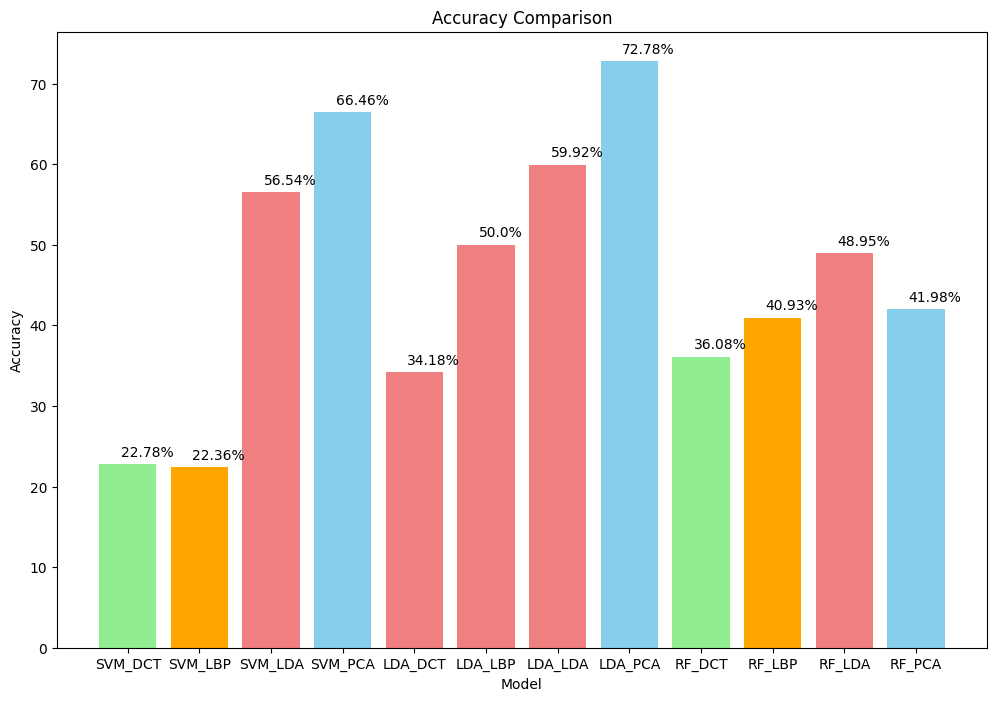

In [37]:
# Function to plot accuracy results

# Colors RED FOR PCA, BLUE FOR LDA
colors = [
    "skyblue" if "PCA" in model_name else "lightcoral" if "LDA" in model_name else "lightgreen" if "DCT" in model_name else "orange"
    for model_name in models_accuracy.keys()
]

# CHANGE ACCURACY TO % AND Plot
models_accuracy_percentage = {k: v * 100 for k, v in models_accuracy.items()}

plt.figure(figsize=(12, 8))
plt.bar(models_accuracy.keys(), models_accuracy_percentage.values(), color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')

for i, v in enumerate(models_accuracy_percentage.values()):
    plt.text(i - 0.1, v + 1, str(round(v, 2)) + '%')

plt.title('Accuracy Comparison')
plt.show()

#### PCA with SVM

In [38]:
# # SVM
# from sklearn import svm
# from sklearn.model_selection import cross_val_score

# # Create an SVM classifier
# clf = svm.SVC(kernel="rbf", class_weight="balanced")

# # Perform 10-fold cross-validation
# scores = cross_val_score(clf, X_pca, y, cv=10)


# # print cross-validation scores with %
# print("Cross-validation scores: {}".format(scores * 100))
# print("Average cross-validation score: {:.2f}%".format(scores.mean() * 100))

# # Train the model
# clf.fit(X_pca, y)

### Save & Load Model

In [39]:
# import pickle

# # if model.pkl not exists, create it
# if not os.path.exists('model.pkl'):
#     with open('model.pkl', 'wb') as f:
#         pickle.dump(clf, f)

In [40]:
# model_filename = './model.pkl'

# pickle.dump(clf, open(model_filename, 'wb'))

# # load the model from disk

# loaded_model = pickle.load(open(model_filename, 'rb'))

# # Test the model on a random image

# index = np.random.randint(len(filtered_dataset['data']))

# test_image = filtered_dataset['data'][index]

# plt.imshow(test_image, cmap='gray')

# test_image = test_image.reshape(1, -1)

# test_image_pca = pca.transform(test_image)

# pred = loaded_model.predict(test_image_pca)

# print("Predicted label:", pred[0])
# print("Actual label:", filtered_dataset['target'][index])

#### Test WITH REAL IMAGE

In [41]:
# test_image = cv2.imread('./Data/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0013.jpg')

# test_image = resize_image([test_image], target_size=(80, 80))[0]

# test_image = gray_scale([test_image])[0]

# # Scale the image
# test_image = scaler.transform(test_image.reshape(1, -1))

# # Reduce the dimensions
# test_image = pca.transform(test_image)

# # Make a prediction

# pred = clf.predict(test_image)[0]

# print("Prediction:", pred)